CIFAR-10  is an established computer-vision dataset used for object recognition. It is a subset of the 80 million tiny images dataset and consists of 60,000 32x32 color images containing one of 10 object classes, with 6000 images per class.
The label classes in the dataset are:

airplane
automobile
bird
cat
deer
dog
frog
horse
ship
truck


In [ ]:
# configuring the path of Kaggle.json file
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# daatset api
!kaggle competitions download -c cifar-10

cifar-10.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
# extracting the compessed Dataset
from zipfile import ZipFile
dataset = '/content/cifar-10.zip'

with ZipFile(dataset,'r') as zip:
  zip.extractall()
  print('The dataset is extracted')

The dataset is extracted


In [ ]:
!ls

cifar-10.zip  sample_data	    test.7z   trainLabels.csv
kaggle.json   sampleSubmission.csv  train.7z


In [ ]:
!pip install py7zr

In [ ]:
import py7zr

archive = py7zr.SevenZipFile('/content/train.7z', mode='r')
archive.extractall()     #archive.extractall(path='/content/Training Data')
archive.close()

In [ ]:
!ls

cifar-10.zip  sample_data	    test.7z  train.7z
kaggle.json   sampleSubmission.csv  train    trainLabels.csv


In [ ]:
import os
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split

In [ ]:
filenames = os.listdir('/content/train')

In [ ]:
len(filenames)

50000

In [ ]:
labels_df = pd.read_csv('/content/trainLabels.csv')

In [ ]:
labels_df.head()

,id,label
0,1,frog
1,2,truck
2,3,truck
3,4,deer
4,5,automobile


In [ ]:
labels_df.label.value_counts()

,count
label,
frog,5000
truck,5000
deer,5000
automobile,5000
bird,5000
horse,5000
ship,5000
cat,5000
dog,5000


In [ ]:
labels_dictionary = {'airplane':0, 'automobile':1, 'bird':2, 'cat':3, 'deer':4, 'dog':5, 'frog':6, 'horse':7, 'ship':8, 'truck':9}

labels = [labels_dictionary[i] for i in labels_df['label']]

In [ ]:
labels[:5]

[6, 9, 9, 4, 1]

In [ ]:
id_list = list(labels_df['id'])

In [ ]:
# convert images to numpy arrays

train_data_folder = '/content/train/'

data = []

for id in id_list:

  image = Image.open(train_data_folder + str(id) + '.png')
  image = np.array(image)
  data.append(image)

In [ ]:
data[0].shape

(32, 32, 3)

array([[[ 59,  62,  63],
        [ 43,  46,  45],
        [ 50,  48,  43],
        ...,
        [158, 132, 108],
        [152, 125, 102],
        [148, 124, 103]],

       [[ 16,  20,  20],
        [  0,   0,   0],
        [ 18,   8,   0],
        ...,
        [123,  88,  55],
        [119,  83,  50],
        [122,  87,  57]],

       [[ 25,  24,  21],
        [ 16,   7,   0],
        [ 49,  27,   8],
        ...,
        [118,  84,  50],
        [120,  84,  50],
        [109,  73,  42]],

       ...,

       [[208, 170,  96],
        [201, 153,  34],
        [198, 161,  26],
        ...,
        [160, 133,  70],
        [ 56,  31,   7],
        [ 53,  34,  20]],

       [[180, 139,  96],
        [173, 123,  42],
        [186, 144,  30],
        ...,
        [184, 148,  94],
        [ 97,  62,  34],
        [ 83,  53,  34]],

       [[177, 144, 116],
        [168, 129,  94],
        [179, 142,  87],
        ...,
        [216, 184, 140],
        [151, 118,  84],
        [123,  92,  72]]], dtype=uint8)
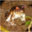

In [ ]:
data[0]

In [ ]:
# convert image list and label list to numpy arrays

X = np.array(data)
Y = np.array(labels)

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [ ]:
print(X.shape, X_train.shape, X_test.shape)

(50000, 32, 32, 3) (40000, 32, 32, 3) (10000, 32, 32, 3)


In [ ]:
# scaling the data

X_train_scaled = X_train/255

X_test_scaled = X_test/255

**Building the Neural Network**

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential, models, layers
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras import optimizers

In [ ]:
convolutional_base = ResNet50(weights='imagenet', include_top=False, input_shape=(256,256,3))
convolutional_base.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 262, 262,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 128, 128,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 128, 128,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 128, 128,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 130, 130,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 64, 64,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 64, 64,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 64, 64,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 64, 64,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 64, 64,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 64, 64,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 64, 64,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 64, 64,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 64, 64,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 64, 64,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 64, 64,    │      1,024 │ conv2_block1_3_c

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 23,534,592 (89.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [ ]:
num_of_classes = 10

model = models.Sequential()
model.add(layers.UpSampling2D((2,2)))
model.add(layers.UpSampling2D((2,2)))
model.add(layers.UpSampling2D((2,2)))
model.add(convolutional_base)
model.add(layers.Flatten())
model.add(layers.BatchNormalization())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.BatchNormalization())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.BatchNormalization())
model.add(layers.Dense(num_of_classes, activation='softmax'))

In [ ]:
model.compile(optimizer=optimizers.RMSprop(learning_rate=2e-5), loss='sparse_categorical_crossentropy', metrics=['acc'])

In [ ]:
history = model.fit(X_train_scaled, Y_train, validation_split=0.1, epochs=8)

Epoch 1/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 451s 351ms/step - acc: 0.3228 - loss: 2.0735 - val_acc: 0.7473 - val_loss: 0.9145
Epoch 2/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 415s 357ms/step - acc: 0.6583 - loss: 1.1063 - val_acc: 0.8817 - val_loss: 0.4676
Epoch 3/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 392s 348ms/step - acc: 0.7889 - loss: 0.7695 - val_acc: 0.9080 - val_loss: 0.3798
Epoch 4/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 451s 357ms/step - acc: 0.8578 - loss: 0.5841 - val_acc: 0.9273 - val_loss: 0.2883
Epoch 5/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 393s 349ms/step - acc: 0.9030 - loss: 0.4528 - val_acc: 0.9355 - val_loss: 0.2632
Epoch 6/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 451s 357ms/step - acc: 0.9270 - loss: 0.3674 - val_acc: 0.9362 - val_loss: 0.2426
Epoch 7/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 442s 357ms/step - acc: 0.9499 - loss: 0.2855 - val_acc: 0.9405 - val_loss: 0.2328
Epoch 8/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 442s 357ms/step - acc: 0.9577 - loss: 0.2429 - val_acc: 0.9420 - val_loss: 0.2160
Epoch 9/

In [ ]:
loss, accuracy = model.evaluate(X_test_scaled, Y_test)
print('Test Accuracy =', accuracy)

313/313 ━━━━━━━━━━━━━━━━━━━━ 39s 110ms/step - acc: 0.9381 - loss: 0.2195
Test Accuracy = 0.9358000159263611


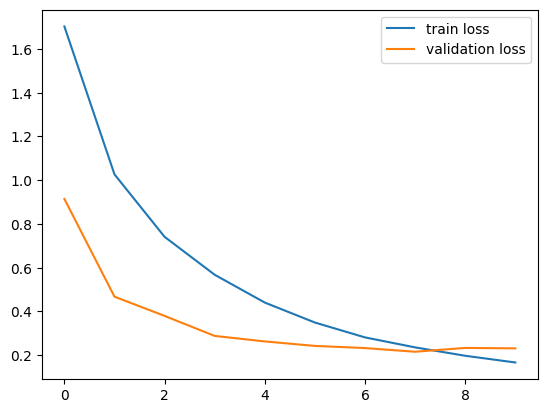

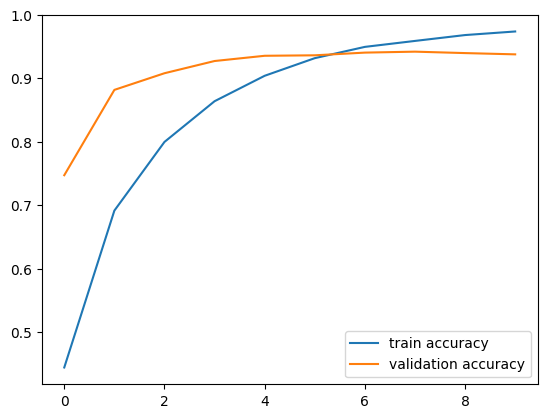

In [ ]:
h = history

# plot the loss value
plt.plot(h.history['loss'], label='train loss')
plt.plot(h.history['val_loss'], label='validation loss')
plt.legend()
plt.show()

# plot the accuracy value
plt.plot(h.history['acc'], label='train accuracy')
plt.plot(h.history['val_acc'], label='validation accuracy')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

y_pred_probs = model.predict(X_test)

y_pred = np.argmax(y_pred_probs, axis=1)

acc = accuracy_score(y_test, y_pred)
print("Accuracy:", acc)

cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)

print("Classification Report:\n", classification_report(y_test, y_pred))